In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from scipy.integrate import trapz # trapezoidal rule to compute integral

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Import and clean data

In [2]:
farm_sizes = pd.read_csv('farm_size_rainforest_sample.csv')[:-2]
prod_volume = pd.read_csv('production_volume.csv', usecols=[0,1])[1:-2]

str2float = lambda x: np.float(x.replace(',', ''))
farm_sizes['prod_area'] = farm_sizes['Area in production (ha)'].apply(str2float)

to_kg = lambda x: np.float(x.replace(',', ''))*46
prod_volume['prod_in_kg'] = prod_volume['Harvest Year 2015-2016'].apply(to_kg)

### Explore data

,# farm,Total area (ha),Area in production (ha),prod_area
0,1,1.20,0.80,0.8
1,2,20.00,20.00,20.0
2,3,8.00,8.00,8.0
3,4,5.60,5.60,5.6
4,5,38.00,38.00,38.0


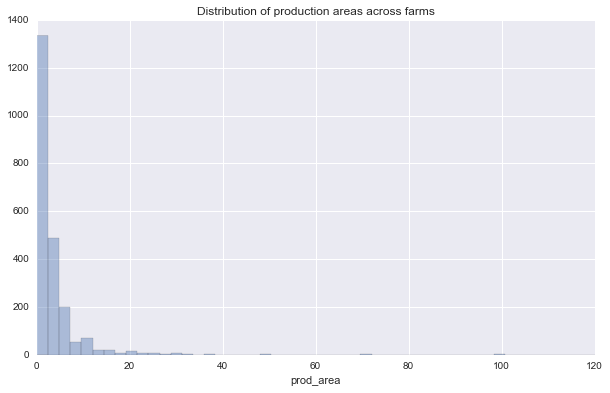

In [3]:
plt.figure(figsize=(10,6))
plt.title('Distribution of production areas across farms')
sns.distplot(farm_sizes.prod_area, kde=False)
farm_sizes.head()

,# farm,Total area (ha),Area in production (ha),prod_area
0,1,1.20,0.80,0.8
1,2,20.00,20.00,20.0
2,3,8.00,8.00,8.0
3,4,5.60,5.60,5.6
4,5,38.00,38.00,38.0


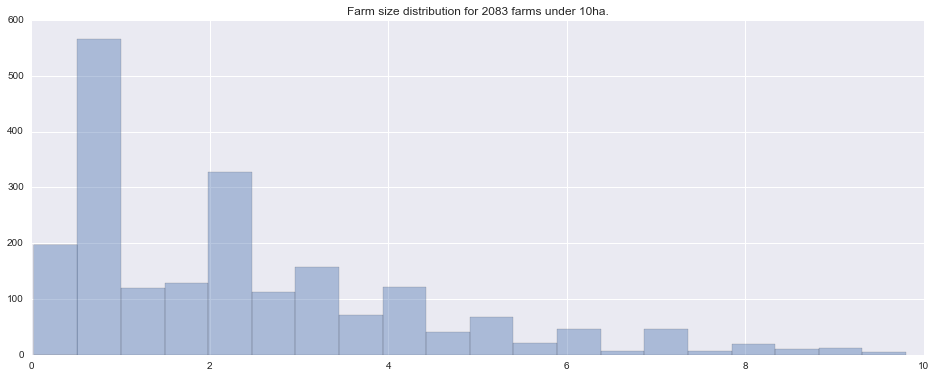

In [4]:
# Investigate round number bias
small_farms = [x for x in farm_sizes.prod_area if x < 10]

plt.figure(figsize=(16,6))
title = 'Farm size distribution for {} farms under 10ha.'
plt.title(title.format(len(small_farms)))
sns.distplot(small_farms, kde=False, bins=20)
farm_sizes.head()

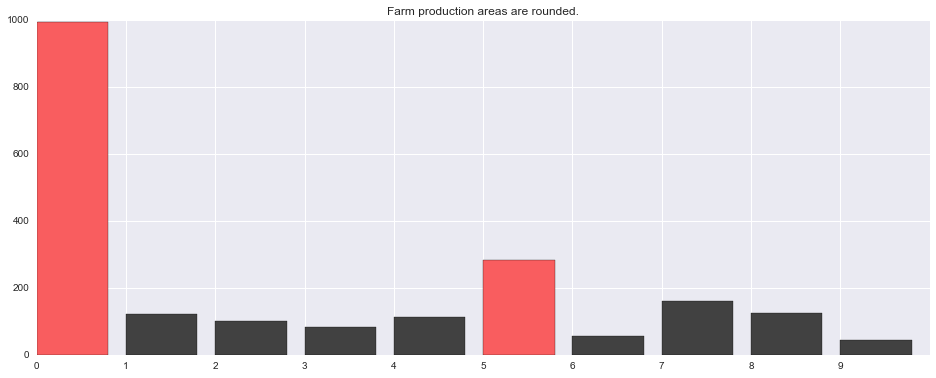

In [5]:
# Investigate round number bias part 2
decimals = defaultdict(int)
for x in small_farms:
    decimals['{:.1f}'.format(float(x))[-1]] += 1

decimals = sorted(decimals.items(), key=itemgetter(0))
r, b = ('#F95D5F','#414141')
colors = [r, b, b, b, b, r, b, b, b, b]
plt.figure(figsize = (16,6))
plt.bar(range(len(decimals)), [x[1] for x in decimals], color = colors)
plt.xticks(range(len(decimals)), [x[0] for x in decimals])
plt.title('Farm production areas are rounded.')

1197/3850 farms produced zero kg.


,# Farm,Harvest Year 2015-2016,prod_in_kg
1,1,111.94,5149.24
2,2,2.55,117.30
3,3,4.44,204.24
5,5,1.09,50.14
6,6,6.25,287.50


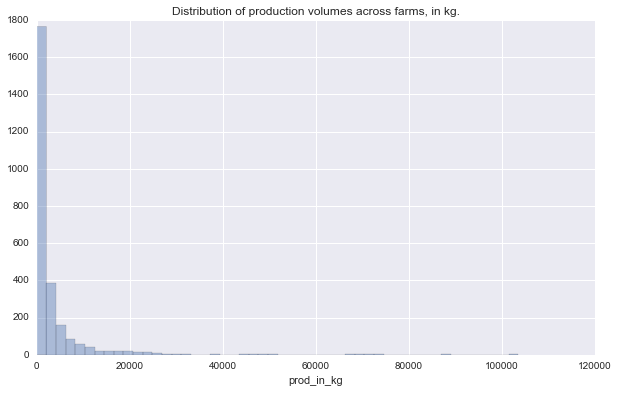

In [6]:
print '{}/{} farms produced zero kg.'.format(len(prod_volume[prod_volume.prod_in_kg == 0]), 
                                             len(prod_volume))
# Only use data from farms that produced something
prod_volume = prod_volume[prod_volume.prod_in_kg > 0]

plt.figure(figsize=(10,6))
plt.title('Distribution of production volumes across farms, in kg.')
sns.distplot(prod_volume.prod_in_kg, kde=False)
prod_volume.head()

### Kernel Density Estimation

In [7]:
def best_kde(dat):
    """ Optimizes KDE params using cross validation. Returns KDE w/best params. """
    
    data = dat[:, None]
    grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, dat.max()/50, 20),
                         'kernel' : ['tophat', 'epanechnikov', 'gaussian']},
                        cv=25)
    grid.fit(data)

    print grid.best_params_
    return grid.best_estimator_

In [22]:
def plot_kde(kde, dat, xlabel, title):
    """ Plots data and KDE curve together. """
    
    x_grid = np.linspace(dat.min(), dat.max(), 500)
    pdf = np.exp(kde.score_samples(x_grid[:, None]))

    fig, ax = plt.subplots(figsize=(14,8))
    ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, color = 'red')
    ax.hist(dat, 100, normed=True, color = 'grey')
    plt.xlabel(xlabel)
    plt.ylabel('Probability density')
    plt.title(title)
    plt.show()

In [9]:
def integrate(bounds, kde, dat, name):
    """ Prints estimated # of farms in costa rica with variable of interest between
        the lower and upper bounds. Separate estimates based on kde curve and on the 
        number of farms in the available data. """

    lower, upper = bounds
    r = np.linspace(lower, upper, 1000)
    integral = trapz(np.exp(kde.score_samples(r.reshape(-1,1))), r )
    empirical = len(dat[dat >= lower][dat <= upper])*(26527./len(dat))
    
    print "{} range: {} to {}".format(name, lower, upper)
    print "Estimated # farms in your range (includes bounds): {:.2f}".format(integral*26527)    
    print '# farms in your range based on multiplying available data: ', empirical

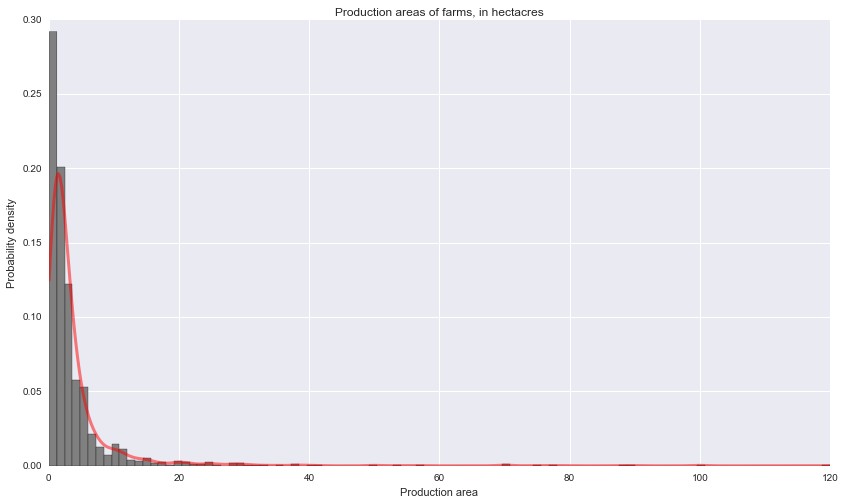

In [23]:
# KDE for production area
prod_area = farm_sizes['prod_area']
kde_area = best_kde(prod_area)
plot_kde(kde_area, prod_area, 'Production area', 
         'Production areas of farms, in hectacres')

In [11]:
# Make area estimates
integrate((10.5, 11.5), kde_area, prod_area, 'Production area')

Production area range: 10.5 to 11.5
Estimated # farms in your range (includes bounds): 254.43
# farms in your range based on multiplying available data:  281.702654867


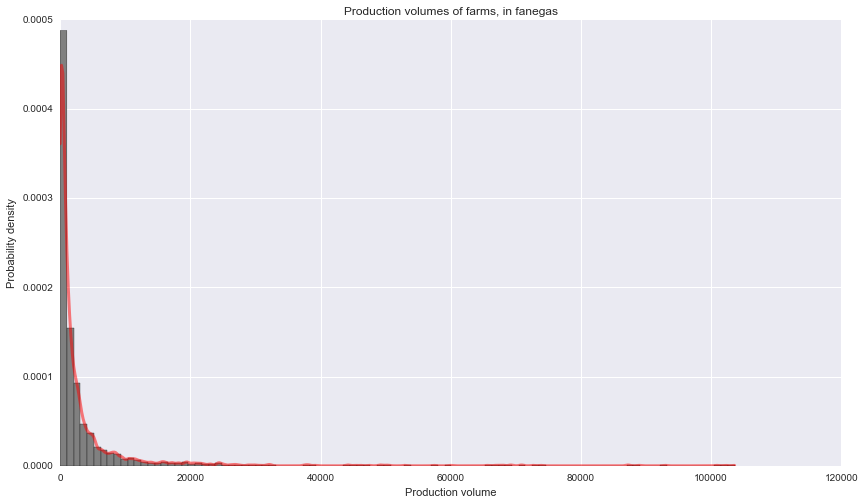

In [24]:
# KDE for prod volume
# prod_vol = prod_volume['prod_in_kg']
# kde_volume = best_kde(prod_vol)
plot_kde(kde_volume, prod_vol, 'Production volume', 
         'Production volumes of farms, in fanegas')

In [13]:
# Make prod volume estimates
integrate((5000, 10000), kde_volume, prod_vol, 'Production volume')

Production volume range: 5000 to 10000
Estimated # farms in your range (includes bounds): 2152.66
# farms in your range based on multiplying available data:  2149.756879
